In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from itertools import combinations, combinations_with_replacement
from utils.plotting import aligned_imshow_cbar

In [2]:
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["xtick.major.width"] = 2
mpl.rcParams["ytick.major.width"] = 2
mpl.rcParams["xtick.major.size"] = 5
mpl.rcParams["ytick.major.size"] = 5

In [3]:
def isoelastic_utility(x, eta):
    """Isoelastic utility for a given wealth.
    
    Args:
        x (array):
            Wealth vector.
        eta (float):
            Risk-aversion parameter.
    
    Returns:
        Vector of utilities corresponding to wealths. For log utility if wealth 
        is less or equal to zero, smallest float possible is returned. For other
        utilites if wealth is less or equal to zero, smallest possible utility, 
        i.e., specicfic lower bound is returned.
        
    Note:
        Not implementef for eta > 1.
    """
    u = np.zeros_like(x)
    if eta > 1:
        return ValueError("eta should be less than 1")
    if np.isclose(eta, 1):
        u[x > 0] = np.log(x[x > 0])
        u[x <= 0] = np.finfo(float).min
    if eta < 1:
        bound = (-1) / (1 - eta)
        u[x > 0] = (np.power(x[x > 0], 1-eta) - 1) / (1 - eta)
        u[x <= 0] = bound
    return u
    
def inverse_isoelastic_utility(u, eta):
    """Inverse isoelastic utility function mapping from utility to wealth.
    
    Args:
        u (array):
            Utility vector.
        eta (float):
            Risk-aversion parameter.
    
    Returns:
        Vector of wealths coresponding to utilities. For 
    """
    if eta > 1:
        return ValueError("eta should be less than 1")
    if np.isclose(eta, 1):
        return np.exp(u)        
    if eta < 1:
        bound = (-1) / (1 - eta)
        x = np.zeros_like(u)
        x[u > bound] = np.power(u[u > bound] * (1 - eta) + 1, 1 / (1 - eta))
        return x

def wealth_change(x, gamma, eta):
    """Apply isoelastic wealth change.
    
    Args:
        x (float):
            Initial wealth vector.
        gamma (float):
            Growth rate.
        eta (float):
            Wealth dynamic parameter.
    """
    return inverse_isoelastic_utility(isoelastic_utility(x, eta) + gamma, eta)
    
def shuffle_along_axis(a, axis):
    """Randomly shuffle multidimentional array along specified axis."""
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)

def create_gambles(c, n_fractals=9):
    """Create list of all gambles. 
    
    Args:
        c (float):
            Max growth rate for gamble space.
        n_fractals (int):
            Number of growth rate samples.
    Returns:
        List of arrays. Each gamble is represented as (2, ) array with growth 
        rates. For n fractals, n(n+1)/2 gambles are created. Order of growth 
        rates doesn't matter since probabilities are assigned equally to both 
        wealth changes.
    """
    gamma_range = np.linspace(-c, c, n_fractals)
    return [
        np.array([gamma_1, gamma_2]) 
        for gamma_1, gamma_2 
        in combinations_with_replacement(gamma_range, 2)
    ]    

def create_gamble_pairs(gambles):
    """Create list of all unique gamble pairs.
    
    Args:
        gambles (list of arrays):
            List of gambles.
    
    Returns:
        List of arrays. Each gamble pair is represented as (2, 2) array with 
        four growth rates for both gambles. Rows corresponds to gambles, columns 
        correspond to individual growth rates within a gamble. All pairs contain
        two unique gambles. For n gambles, n(n-1)/2 gamble pairs are created.
    """    
    return [
        np.concatenate((g1[np.newaxis], g2[np.newaxis]), axis=0) 
        for g1, g2 in combinations(gambles, 2)
        ]

def create_experiment(gamble_pairs):
    """Creates experiment array.
    
    Args:
        gamble_pairs (list of arrays):
            List of gamble pairs.
    
    Returns:
        Array of size (2, 2, n_trials). First two dimensions correspond to 
        gamble pair, third dimension correspond to subsequent trials.  
    """
    return np.stack(gamble_pairs, axis=2)

def is_mixed(gp):
    """Decision if a gamble pair is composed of two mixed gambles."""
    return np.product(gp[0]) < 0 and np.product(gp[1]) < 0

def is_nobrainer(gp):
    """Decision if a gamble pair is nobrainer."""
    return len(np.unique(gp)) != 4

def disagreement_prob(p1, p2):
    """Softmax disagreement.
    
    Args:
        p1 (array; n_trials x n_simulations):
            Choice probability array for agent 1. 
        p2 (array):
            Choice probability array for agent 2.
    """
    return np.nansum(np.abs(p1 - p2)) / np.prod(p1.shape)

def disagreement(y1, y2):
    """Disagreement between agents.
    
    Args:
        y1 (array):
           Response array for agent 1. Shape is (n_trials, n_simulations).             
        y2 (array; n_trials x n_simulations):
            Response array for agent 2.
            
    Note:
        Response coding required:
             0: Left gamble chosen.
             1: Right gamble chosen.
            99: No choice made.
            
    Returns:
        Disagreement probability.
    """
    y1_vec = y1.flatten()
    y2_vec = y2.flatten()

    # filter out corresponding trials with no responses
    active = (y1_vec != 99) & (y2_vec != 99)

    return np.sum(y1_vec[active] == y2_vec[active]) / np.prod(y1.shape)

def bankruptcy_chance(x):
    """Proportion of simulations that went bankrupt.
    
    Args:
        x (array; n_trials x n_simulations):
            Wealth trajectories array.
            
    Returns:
        Proportion of trajectories that ended up with 0 wealth.
    """
    return np.mean(x[-1] == 0)

def richness_chance(x, x_limit):
    """Proportion of simulations that exceeded wealth limit.
    
    Args:
        x (array; n_trials x n_simulations):
            Wealth trajectories array.
            
    Returns:
        Proportion of trajectories that ended up with wealth higher or equal to 
        x_limit.
    """
    return np.mean(x[-1] >= x_limit)

def payout_stats(x):
    payouts_all = x[-1]
    payouts_act = x[-1][x[-1] > 0]
    return {
        p_name: {
            "mean": np.mean(p),
            "median": np.median(p),
            "min": np.min(p),
            "max": np.max(p), 
            "std": np.std(p),
        } 
        for p_name, p 
        in zip(["all", "active"], [payouts_all, payouts_act])
    }

def run_simulation(experiment, trial_order, eta_dynamic, eta_agent, x_0, 
                   x_limit, beta):
    """Simulate wealth trajectories for gamble experiment. 
    
    Args:
        experiment:
            It has shape (2, 2, n_trials).
        trial_order:
            It has shape (n_trials, n_simulations).
        eta_dynamic (float):
            Risk-aversion for time-optimal gent in a given dynamic.
        eta_agent (float):
            Risk-aversion of the agent.
        x0 (float):
            Initial wealth.
        x_limit (float):
            Wealth limit. If an agent exceeds it, the experiment is over.
        beta (float):
            Softmax sensitivity for isoelastic agent.
            
    Returns:
        ...
    """
    # initialize wealth array x, choice probability array p, and choice array y
    n_trials, n_sims = trial_order.shape
    p = np.full((n_trials, n_sims), fill_value=np.nan)
    y = np.full((n_trials, n_sims), fill_value=99, dtype=np.int8)
    x = np.zeros((n_trials + 1, n_sims), dtype=np.float64)
    x[0] = x_0

    for t in range(n_trials):
        # filter active simulations i.e, agent is not broke and didn't exceed 
        # payout limit
        is_broke = x[t] <= 0
        is_rich = x[t] >= x_limit
        active = ~is_broke & ~is_rich
        n_active = np.sum(active)

        # gamble pair
        gp = experiment[:, :, trial_order[t, active]]

        # compute agents choice (coded 0, 1 for left, right)
        u = isoelastic_utility(
            x[t, active], eta_agent)
        u_gp = isoelastic_utility(
            wealth_change(x[t, active], gp, eta_dynamic), eta_agent)
        du_gp = u - u_gp
        gp_diff = np.mean(du_gp[0], axis=0) - np.mean(du_gp[1], axis=0)
        p[t, active] = softmax(gp_diff, beta)
        y[t, active] = (p[t, active] > np.random.random(size=n_active)) * 1

        # update wealth
        coin_toss = np.random.randint(0, 2, size=n_active)
        chosen_gamble = gp[y[t, active], :, np.arange(n_active)]
        realized_gamma = chosen_gamble[np.arange(n_active), coin_toss]
        x[t + 1, active] = wealth_change(x[t, active], realized_gamma, eta_dynamic)
        x[t + 1, is_rich] = x[t, is_rich]

    # trim excessive wealth
    x[x > x_limit] = x_limit

    return x, p, y

def plot_wealth_trajectories(x):
    """..."""
    fig, ax = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [4, 1]})

    ax[0].plot(x, c="k", alpha=0.025);
    ax[0].plot(np.mean(x, axis=1), c="r", alpha=0.5, lw=3);
    ax[0].set_xlim([0, len(x) - 1])
    ax[0].set_xlabel("Trial")
    ax[0].set_ylabel("Wealth [DKK]")

    ax[1].hist(x[-1], bins=30, orientation="horizontal", color="k", alpha=0.25)
    ax[1].axhline(np.mean(x[-1]), c="r", alpha=0.5, lw=3)
    ax[1].set_xlabel("counts")
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_yticks([])

    plt.tight_layout()
    
def softmax(x, beta):
    """Softmax choice function.
    
    Args:
        beta (float):
            Precision parameter (inverse temperature)
    
    Returns:
        Choice probability.
    """
    return np.power(1 + np.exp((-beta) * x), -1)  

def calculate_beta(eta_dynamic, eta_agent, c, x_0, x_limit, p_threshold):
    # extreme wealth changes 
    x_f = wealth_change(np.array([x_0, x_0]), np.array([-c, c]), eta_dynamic)
    x_f[x_f < 0] = 0
    x_f[x_f > x_limit] = x_limit

    # utility changes
    u_f = isoelastic_utility(x_f, eta_agent)
    du = u_f[1] - u_f[0]

    beta = np.log(p_threshold / (1 - p_threshold)) / du
    return beta

def agent_name(eta_agent):
    if eta_agent == -1:
        return "rse"
    if eta_agent == 0:
        return "lin"
    if eta_agent == 1:
        return "log"
    return str(eta_agent)

### Settings
- `x_0`: initial wealth
- `x_limit`: wealth limit per agent
- `n_fractals`: number of distinct fractals
- `n_simulations`: number of simulations run in paralell
- `eta_dynamic`: wealth dynamic parameter
- `c`: maximum fractal growth rate; should be adjusted for each dynamic
- `p_threshold`: critial choice probaiblity used to normalize softmax sensitivity across agents. Normalization ensures that all isoelastic agnets would choose the best fractal over the worst fractal with `p_threshold` probability. Values closer to one indicate more sensitive agents and more deterministic choices.
- `agents`: list of agent's risk attitude values 

In [4]:
x_0 = 1000
x_limit = 4000
n_fractals = 9
n_simulations = 1_000
eta_dynamic = 0
c = 35
p_threshold = 0.99
agents = [-1, 0, 1]

In [5]:
# Store relevant statistics
stats = pd.DataFrame()

# Setup the experiment
gambles = create_gambles(c, n_fractals=n_fractals)
gambles = [g for g in gambles if np.mean(g) < c]    
gamble_pairs = create_gamble_pairs(gambles)
gamble_pairs_filtered = [gp for gp in gamble_pairs if not is_nobrainer(gp)]
experiment = create_experiment(gamble_pairs_filtered)
n_trials = experiment.shape[-1]
trial_order = np.repeat(np.arange(n_trials)[:, np.newaxis], n_simulations, axis=1)
trial_order = shuffle_along_axis(trial_order, axis=0)

# Run simulations

x_dct, p_dct, y_dct = {}, {}, {}

for eta_agent in agents:

    # Normalize precision
    beta = calculate_beta(
        eta_dynamic=eta_dynamic,
        eta_agent=eta_agent,
        x_0=x_0,
        x_limit=x_limit,
        p_threshold=p_threshold,
        c=c,
    )

    x_dct[eta_agent], p_dct[eta_agent], y_dct[eta_agent] = run_simulation(
        experiment=experiment,
        trial_order=trial_order,
        eta_dynamic=eta_dynamic,
        eta_agent=eta_agent,
        x_0=x_0,
        x_limit=x_limit,
        beta=beta,
    )

<ipython-input-3-bd1a3f6ce264>:311: RuntimeWarning: divide by zero encountered in double_scalars
  beta = np.log(p_threshold / (1 - p_threshold)) / du


Text(0.5, 1.0, 'Wealth trajectories')

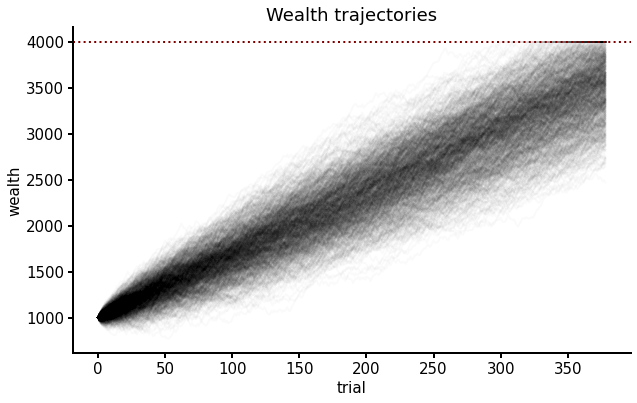

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_dct[0], c="k", alpha=.02)

ax.axhline(x_limit, c="maroon", linestyle=':')
ax.set_xlabel("trial")
ax.set_ylabel("wealth")
ax.set_title("Wealth trajectories")

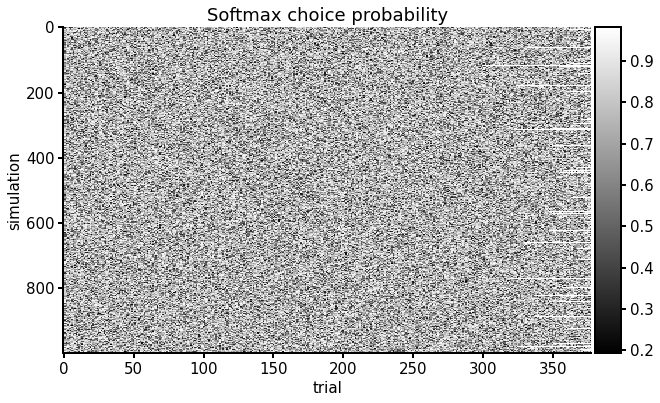

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(p_dct[0].T, aspect="auto", interpolation="none", cmap="gray")

ax.set_xlabel("trial")
ax.set_ylabel("simulation")
ax.set_title("Softmax choice probability")
aligned_imshow_cbar(ax, im)

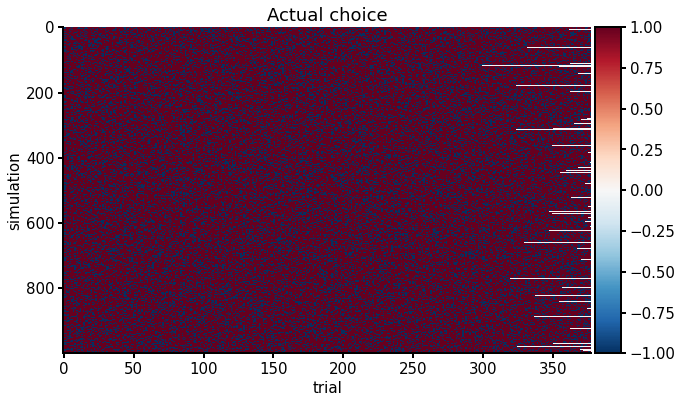

In [8]:
y = y_dct[0].copy()
y[y == 0] = -1
y[y == 99] = 0

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(y.T, aspect="auto", interpolation="none", cmap="RdBu_r")

ax.set_xlabel("trial")
ax.set_ylabel("simulation")
ax.set_title("Actual choice")
aligned_imshow_cbar(ax, im)